<a href="https://colab.research.google.com/github/Bambani2003/Data_Science_Projects/blob/main/Decision_Trees/Titanic_Survivors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using Decision Tree Ensembles to predict what sort of people had better odds to live**

In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

**EDA**

In [2]:
# Load in the train and test datasets

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
PassengerId = test['PassengerId']
display(train.head())
display(test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
# Create a new column for type of ticket and one hot encode it for both training and testing data

train['Ticket_type'] = train['Ticket'].apply(lambda x: x[0:3])
train['Ticket_type'] = train['Ticket_type'].astype('category')
train['Ticket_type'] = train['Ticket_type'].cat.codes
display(train.head())
test['Ticket_type'] = test['Ticket'].apply(lambda x: x[0:3])
test['Ticket_type'] = test['Ticket_type'].astype('category')
test['Ticket_type'] = test['Ticket_type'].cat.codes
display(test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,124
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,137
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,148
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,97


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,58
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,71
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,32
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,55
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,54


**Feature Engineering**

In [4]:
# Combining the test and train data for easier access
full_data = [train, test]

# Counting number of words in name
train['Words_Count'] = train['Name'].apply(lambda x: len(x.split()))
test['Words_Count'] = test['Name'].apply(lambda x: len(x.split()))

# Feature that tells whether a passenger had a cabin or not
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# One Hot Encoding
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

display(train.head())
display(test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type,Words_Count,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,124,4,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,137,7,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,148,3,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,3,7,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,97,4,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",1


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type,Words_Count,Has_Cabin,FamilySize,IsAlone,Title
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,0,NaN,2,58,3,0,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,2,1,0,363272,0,NaN,0,71,5,0,2,0,3
2,894,2,"Myles, Mr. Thomas Francis",1,3,0,0,240276,1,NaN,2,32,4,0,1,1,1
3,895,3,"Wirz, Mr. Albert",1,1,0,0,315154,1,NaN,0,55,3,0,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,1,3101298,1,NaN,0,54,6,0,3,0,3


In [5]:
# Feature selection

drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'CategoricalAge', 'CategoricalFare']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements[:-2], axis = 1)
display(train.head())
display(test.head())

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Ticket_type,Words_Count,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,124,4,0,2,0,1
1,1,1,0,2,0,3,1,137,7,1,2,0,3
2,1,3,0,1,0,1,0,148,3,0,1,1,2
3,1,1,0,2,0,3,0,3,7,1,2,0,3
4,0,3,1,2,0,1,0,97,4,0,1,1,1


,Pclass,Sex,Age,Parch,Fare,Embarked,Ticket_type,Words_Count,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,58,3,0,1,1,1
1,3,0,2,0,0,0,71,5,0,2,0,3
2,2,1,3,0,1,2,32,4,0,1,1,1
3,3,1,1,0,1,0,55,3,0,1,1,1
4,3,0,1,1,1,0,54,6,0,3,0,3


<Axes: title={'center': 'Pearson Correlation of Features'}>

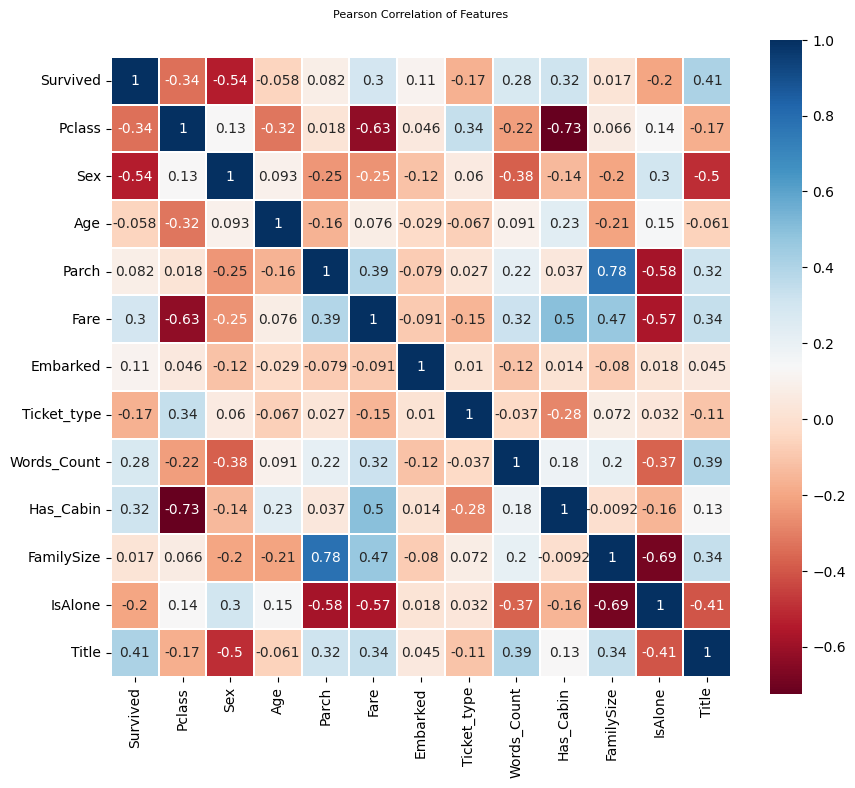

In [6]:
# Correlation Heatmap to find redundant datasets

colormap = plt.cm.RdBu
plt.figure(figsize=(10,8.5))
plt.title('Pearson Correlation of Features', y=1.05, size=8)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

**Inference:**\
Since there is no strong correlation between any of the features, none of them are superfluous or useless.\
The closest related features are Family Size and Parch (Parents + Children) but keeping both of them increases the model's accuracy.

In [7]:
# # Deciding which one to remove

# display(np.mean(train.corr()['Parch']))
# display(np.mean(train.corr()['FamilySize']))
# train = train.drop(['Parch'], axis = 1)
# test  = test.drop(['Parch'], axis = 1)

**Bulding ML Models**

In [8]:
# XGBoost

y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values
gbm = xgb.XGBClassifier(
 n_estimators= 2000, max_depth= 4, min_child_weight= 2, gamma=0.9, subsample=0.8, seed=69,
 colsample_bytree=0.8, objective= 'binary:logistic', nthread= -1, scale_pos_weight=1)
gbm.fit(x_train, y_train)
xgb_predictions = gbm.predict(x_test)
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId, 'Survived': xgb_predictions })

In [9]:
# Ensemble Modelling

import requests
import io
url="https://github.com/thisisjasonjafari/my-datascientise-handcode/raw/master/005-datavisualization/titanic.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))
test_data_with_labels = c
test_data = pd.read_csv('/content/test.csv')
for i, name in enumerate(test_data_with_labels['name']):
    if '"' in name:
        test_data_with_labels['name'][i] = re.sub('"', '', name)
for i, name in enumerate(test_data['Name']):
    if '"' in name:
        test_data['Name'][i] = re.sub('"', '', name)
survived = []
for name in test_data['Name']:
    survived.append(int(test_data_with_labels.loc[test_data_with_labels['name'] == name]['survived'].values[-1]))
submission = pd.read_csv('/content/gender_submission.csv')
submission['Survived'] = survived
submission.to_csv('ground_truth.csv', index=False)

In [10]:
# Calculating the accuracy

StackingSubmission.to_csv("XGB.csv", index=False)
count = 0
for i in range(len(StackingSubmission)):
    if StackingSubmission['Survived'][i] == submission['Survived'][i]:
        count+=1
print(count)
print(f"Accuracy of our model is {count/len(submission)*100}%")

322
Accuracy of our model is 77.03349282296651%
